<a href="https://colab.research.google.com/github/VeereshShringari/myKagglecode/blob/master/resnet5_keras_baseline_COVID_LFLImages_15May.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ResNet50 Keras baseline model

This notebook takes you through some important steps in building a deep convnet in Keras for multilabel classification of brain CT scans. 


*Update (1):*
* *training for 4 epochs instead of 3.*
* *batch size lowered to 16 from 32.*
* *training without learning rate decay.*
* *Weighted BCE instead of "plain" BCE*
* *training data lowered to 80% from 90%.*


*Update (2):*
* *adding competition metric for training*
* *using custom Callback for validation and test sets instead of the `run()` function and 'global epochs'*
* *training with "plain" BCE again*
* *merging TestDataGenerator and TrainDataGenerator into one*
* *adding undersampling (see inside `on_epoch_end`), will now run 6 epochs*

*Update (3):*
* *skipping/removing windowing (value clipping), but the transformation to Hounsfield Units is kept*
* *removing initial layer (doing np.stack((img,)&ast;3, axis=-1)) instead*
* *reducing learning rate to 5e-4 and add decay*
* *increasing batch size to 32 from 16*
* *Increasing training set to 90% of the data (10% for validation)*
* *slight increase in undersampling*
* *fixed some hardcoding for input dims/sizes*

In [0]:
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [0]:
import collections
from datetime import datetime
from math import ceil, floor
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import sys



import cv2
import tensorflow as tf
import keras


from keras_applications.resnet import ResNet50
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import ShuffleSplit

from tensorflow.keras.applications import imagenet_utils
preprocess_input = imagenet_utils.preprocess_input

WEIGHTS_PATH = 'drive/My Drive/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


TEST_IMAGES_DIR = 'drive/My Drive/data/'
TRAIN_IMAGES_DIR = 'drive/My Drive/data/LFA_Iamges/Images/'





In [11]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
WEIGHTS_PATH

'drive/My Drive/resnet50_weights_tf_dim_ordering_tf_kernels.h5'

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [15]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1k2oYVB5FouB4ZR48A-Cu58maNiAcnHHLYaOUfEqhB28')
sheet = wb.sheet1
data = sheet.get_all_values()
df_labels = pd.DataFrame(data)
#df_labels.drop(["reviewer", "Control_intensity","IgG_intensity", "IgM_intensity"],axis=1 )
cols = [1, 2,3, 4]
df_labels.drop(df_labels.columns[cols],axis=1,inplace=True)

df_labels.columns = df_labels.iloc[0]
df_labels = df_labels.iloc[1:]
df_labels['Assay_no.']=df_labels['Assay_no.'].astype(str).astype(int)
df_labels['Assay_no.'].dtypes
df_labels['Assay_no.'] = df_labels['Assay_no.'].apply(lambda x: '{0:0>4}'.format(x))
df_labels['Assay_no.'].head(11)

1     0001
2     0002
3     0003
4     0004
5     0005
6     0006
7     0007
8     0008
9     0009
10    0010
11    0011
Name: Assay_no., dtype: object

drive/My Drive/data/LFA_Iamges/Images/0031.jpg
drive/My Drive/data/LFA_Iamges/Images/0034.jpg
drive/My Drive/data/LFA_Iamges/Images/0030.jpg
drive/My Drive/data/LFA_Iamges/Images/0035.jpg
drive/My Drive/data/LFA_Iamges/Images/0028.jpg
drive/My Drive/data/LFA_Iamges/Images/0036.jpg
drive/My Drive/data/LFA_Iamges/Images/0027.jpg
drive/My Drive/data/LFA_Iamges/Images/0008.jpg
drive/My Drive/data/LFA_Iamges/Images/0007.jpg
drive/My Drive/data/LFA_Iamges/Images/0013.jpg
drive/My Drive/data/LFA_Iamges/Images/0015.jpg
drive/My Drive/data/LFA_Iamges/Images/0024.jpg
drive/My Drive/data/LFA_Iamges/Images/0022.jpg
drive/My Drive/data/LFA_Iamges/Images/0003.jpg
drive/My Drive/data/LFA_Iamges/Images/0012.jpg
drive/My Drive/data/LFA_Iamges/Images/0019.jpg
drive/My Drive/data/LFA_Iamges/Images/0004.jpg
drive/My Drive/data/LFA_Iamges/Images/0002.jpg
drive/My Drive/data/LFA_Iamges/Images/0005.jpg


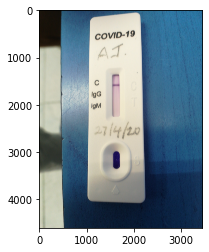

In [16]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

data_dir = pathlib.Path(".")
images = list(data_dir.glob('drive/My Drive/data/LFA_Iamges/Images/*.jpg'))
new_width = 3000
new_height = 1000
for image_path in images:
    print(image_path)
    im = cv2.imread(str(image_path))
    #display.display(im)
    width, height,_ = im.shape   # Get dimensions
    if width < height:
      M = cv2.getRotationMatrix2D((height/2,width/2),90,1)
      im = cv2.warpAffine(im,M,(height,width))
    plt.imshow(im.astype('uint8'))
plt.show()


In [17]:
im.shape

(4608, 3456, 3)

### 1. Helper functions

* normalizing the pixel values between -1 and 1 
* read and transform dcms to 3-channel inputs for e.g. ResNet50.

\* Source for windowing (although now partly removed from this kernel): https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing

In [0]:
def _normalize(img):
    if img.max() == img.min():
        return np.zeros(img.shape)-1
    return 2 * (img - img.min())/(img.max() - img.min()) - 1


  
def _read(path, desired_size, augment_data=0, plot=False):
    """Will be used in DataGenerator
    Loads image, crops and resizes. With optional image data augmentation.
    We assume that the image has been centered. 
    Input:
    ----------------------------------
    desired_size     :  desired size for the image (tuple)
    augment_data     :  nb of data augmented samples (int)
    """
    new_width, new_height,_ = desired_size
    print (path)
    img = cv2.imread(path)
    rows, cols,_ = img.shape
    #https://stackoverflow.com/questions/57217941/converting-all-files-jpg-to-png-from-a-directory-in-python
    #https://scottontechnology.com/open-multiple-images-opencv-python/
    if img.endswith(".jpg"):
       img=img+'.jpeg'
       rgb_im = im.convert('RGB')
       rgb_im.save(img)
    if rows < cols:  
      M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
      img = cv2.warpAffine(img,M,(cols,rows))
    res = cv2.resize(img, dsize=desired_size[:2], interpolation=cv2.INTER_CUBIC)
    samples = np.expand_dims(res, 0)
    if augment_data>0:
        # create image data augmentation generator
        datagen = ImageDataGenerator(rotation_range=90,
                                     width_shift_range=[-100,100])
        # prepare iterator
        it = datagen.flow(samples, batch_size=1)
        for i in range(augment_data):
          batch = it.next()    # generate batch of images
          image = batch[0]
          samples = np.vstack((samples, np.expand_dims(image, 0)))
          if plot:
            plt.subplot(330 + 1 + i)
            plt.imshow(batch[0].astype('uint8'))
          #img = np.stack((res,)*3, axis=-1)
    if plot: plt.show()
    print('samples size in read:', samples.shape)
    return samples


In [36]:
test = _read('drive/My Drive/data/LFA_Iamges/Images/0031.jpg',(512,512,3),9, plot=True)
print(test.shape)

drive/My Drive/data/LFA_Iamges/Images/0031.jpg


AttributeError: ignored

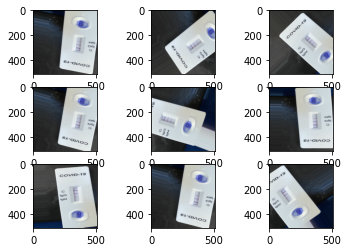

In [20]:


from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import scipy as sc

img = cv2.imread('drive/My Drive/data/image0.jpg')
# convert to numpy array
res = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
data = res
# expand dimension to one sample

samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range = 90, width_shift_range=[-100,100])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

### 2. Data generators

Inherits from keras.utils.Sequence object and thus should be safe for multiprocessing.


In [0]:


class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, img_labels, batch_size=1, img_size=(512, 512,3), 
                 img_dir=TRAIN_IMAGES_DIR, n_classes = 4, train =True,
                 n_augment = 9, shuffle=True,
                 *args, **kwargs):

        self.list_IDs = list_IDs
        self.indices = np.arange(len(self.list_IDs))
        self.img_labels = img_labels ### contains col1: names of images for loading + col2(!exits fr test) for labels
        self.n_classes = n_classes   ### nb of classes
        self.n_augment = n_augment   ### nb of additional data samples
        self.batch_size = batch_size
        self.img_size = img_size    ###  desired image size: (width, height, n_channels)
        self.img_dir = img_dir
        self.shuffle = shuffle
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size: (index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        if self.train:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        self.indices = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, list_IDs_temp):
        print("Self image size",self.img_size )
        X = np.empty((self.batch_size * (self.n_augment + 1), *self.img_size))
        
        if self.train: # training phase
            Y = np.zeros((self.batch_size * (self.n_augment + 1), self.n_classes),
                          dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
              test = _read(self.img_dir+self.img_labels['ID'].loc[ID] +".jpg",
                              self.img_size,  augment_data= self.n_augment, plot=False)
              print("Dim data gen",  test.shape)
              X[i:(i +self.n_augment + 1),] = test
              ### Convert label  into one hot vector
              Y[i:(i +self.n_augment + 1), int(self.img_labels['label'].loc[ID])] = 1

            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+self.img_labels['ID'].loc[ID] +".jpg",
                              self.img_size, augment_data=0, plot=False)      
            return X

### 3a. loss function and metric

In [0]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([1., 2., 2., 2.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for the this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([1., 2., 2., 2.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [1., 2., 2., 2.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

def sparse_categorical_crossentropy(y_true, y_pred, from_logits=False, axis=-1):
    return K.sparse_categorical_crossentropy(
        y_true, y_pred, from_logits=from_logits, axis=axis)

### 3b. Model

Model is divided into three parts: <br> 

* (REMOVED) The initial layer, which will transform/map input image of shape (\_, \_, 1) to another "image" of shape (\_, \_, 3).

* The new input image is then passed through ResNet50 (which I named "engine"). ResNet50 could be replaced by any of the available architectures in keras_application.

* Finally, the output from ResNet50 goes through average pooling followed by a dense output layer.

In [0]:
class PredictionCheckpoint(keras.callbacks.Callback):
    
    def __init__(self, test_df, valid_df, n_classes =4,
                 test_images_dir=TEST_IMAGES_DIR, 
                 valid_images_dir=TRAIN_IMAGES_DIR, 
                 batch_size=32, input_size=(224, 224, 3)):
        
        self.test_df = test_df
        self.valid_df = valid_df
        self.test_images_dir = test_images_dir
        self.valid_images_dir = valid_images_dir
        self.batch_size = batch_size
        self.input_size = input_size
        self.n_classes = n_classes
        
        
    def on_train_begin(self, logs={}):
        self.test_predictions = []
        self.valid_predictions = []
        
    def on_epoch_end(self,batch, logs={}):
        self.test_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.test_df.index, test_df,
                              batch_size=self.batch_size, img_size=self.input_size, 
                              img_dir=self.test_images_dir, n_classes = self.n_classes,
                              train =False, n_augment = 0, shuffle=True),
                verbose=2)[:len(self.test_df)])
        
        self.valid_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.valid_df.index, valid_df,
                              batch_size=self.batch_size, img_size=self.input_size, 
                              img_dir=self.valid_images_dir, n_classes = self.n_classes,
                              train =False, n_augment = 0, shuffle=True),
                verbose=2)[:len(self.valid_df)])
        valid_labels = np.zeros((self.valid_df.shape[0], self.n_classes))
        valid_labels[np.arange(self.valid_df.shape[0]), self.valid_df['label']] = 1
        print('valid_labels', valid_labels )
        print('pred_labels', self.valid_predictions)
        print("validation loss: %.4f" %
              weighted_log_loss_metric(valid_labels, 
                                   np.average(self.valid_predictions, axis=0)))
        
        # here you could save the predictions with np.save()


class MyDeepModel:
    
    def __init__(self, engine, input_dims, batch_size=5, num_epochs=4,
                 n_classes=4, learning_rate=1e-3, n_augment = 9,
                 decay_rate=1.0, decay_steps=1, weights=WEIGHTS_PATH_NO_TOP, verbose=1):
        
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.n_augment = n_augment
        self.weights = weights
        self.verbose = verbose
        self._build()

    def _build(self):
        self.engine.trainable = True
        
      
    
        engine = self.engine(include_top=False,
                             weights=self.weights, input_shape=(*self.input_dims[:2], 3),
                             backend = keras.backend, layers = keras.layers, 
                             models = keras.models, utils = keras.utils,)
        set_trainable = False
        for layer in engine.layers:
            if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
              set_trainable = True
            if set_trainable:
              layer.trainable = True
            else:
              layer.trainable = False
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)
        out = keras.layers.Dense(self.n_classes, activation="sigmoid", name='dense_output')(x)

        self.model = keras.models.Model(inputs=engine.input, outputs=out)
        # loss function has been changed needs to be investigated.
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=keras.optimizers.Adam(0.0),
                           metrics=['accuracy'])
    

    def fit_and_predict(self, train_df, valid_df, test_df):
        
        # callbacks
        pred_history = PredictionCheckpoint(test_df, valid_df,
                                            n_classes=self.n_classes,
                                            batch_size=self.batch_size,
                                            input_size=self.input_dims)
        checkpointer = keras.callbacks.ModelCheckpoint(filepath='%s-{epoch:02d}.hdf5' % self.engine.__name__, verbose=1, save_weights_only=True, save_best_only=False)
        scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))
        self.model.fit_generator(
            DataGenerator(
                list_IDs = train_df.index, 
                img_labels = train_df,
                batch_size=self.batch_size,
                img_size=self.input_dims,
                img_dir=TRAIN_IMAGES_DIR,
                n_classes = self.n_classes,
                train=True,
                n_augment = self.n_augment,
                shuffle = True
            ),
            epochs=self.num_epochs,
            verbose=self.verbose,
            use_multiprocessing=True,
            workers=4#,
            #callbacks=[history]
            #callbacks=[tensorboard_callback]
        )
        
        return pred_history
    
    def save(self, path):
        self.model.save_weights(path)
    
    def load(self, path):
        self.model.load_weights(path)

In [24]:
WEIGHTS_PATH_NO_TOP

'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

### 4. Read csv files


In [0]:
def read_testset(filename="drive/My Drive/data/classification_labels.txt"):
    ''' 
    Data in data folder
    '''
    wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1k2oYVB5FouB4ZR48A-Cu58maNiAcnHHLYaOUfEqhB28')
    sheet = wb.sheet1
    data = sheet.get_all_values()
    df = pd.DataFrame(data)
    cols = [1, 2,3, 4]
    df.drop(df.columns[cols],axis=1,inplace=True)
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    
    #df = pd.read_csv(filename, sep=" ", header=None)
    df.rename(columns={'Assay_no.': 'ID', 'Result': 'label'})
    df.columns = ["ID", "label"]
    return df

def read_trainset(filename="drive/My Drive/data/classification_labels.txt"):
    ''' 
    Data in data folder
    '''
    wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1k2oYVB5FouB4ZR48A-Cu58maNiAcnHHLYaOUfEqhB28')
    sheet = wb.sheet1
    data = sheet.get_all_values()
    df = pd.DataFrame(data)
    cols = [1, 2,3, 4]
    df.drop(df.columns[cols],axis=1,inplace=True)
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df['Assay_no.']=df['Assay_no.'].astype(str).astype(int)
    #df['Assay_no.'].dtypes
    df['Assay_no.'] = df['Assay_no.'].apply(lambda x: '{0:0>4}'.format(x))
    
    #df = pd.read_csv(filename, sep=" ", header=None)
    df.rename(columns={'Assay_no.': 'ID', 'Result': 'label'})
    df.columns = ["ID", "label"]
    return df

    
test_df = read_testset()
df = read_trainset()

In [32]:
df.head(3)

,ID,label
1,0001,Positive
2,0002,Negative
3,0003,Negative


In [27]:
test_df.head(3)

,ID,label
1,1,Positive
2,2,Negative
3,3,Negative


### 5. Train model and predict

*Using train, validation and test set* <br>

Training for 6 epochs with Adam optimizer, with a learning rate of 0.0005 and decay rate of 0.8. The validation predictions are \[exponentially weighted\] averaged over all 6 epochs (same goes for the test set submission later). `fit_and_predict` returns validation and test predictions for all epochs.


In [33]:
# train set (80%) and validation set (20%)
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(df.index)

# lets go for the first fold only
train_idx, valid_idx = next(ss)

# obtain model
model = MyDeepModel(engine=ResNet50, input_dims=(224,224, 3),
                    batch_size=3, learning_rate=5e-5, n_classes=4,
                    num_epochs=6, decay_rate=0.8, decay_steps=1,
                    weights='imagenet', verbose=2)

# obtain test + validation predictions (history.test_predictions, history.valid_predictions)
history = model.fit_and_predict(df.iloc[train_idx], df.iloc[valid_idx], test_df)


Epoch 1/6
Epoch 1/6
Self image size (224, 224, 3)
Self image size (224, 224, 3)
Self image size (224, 224, 3)
drive/My Drive/data/LFA_Iamges/Images/0020.jpg
Self image size (224, 224, 3)
drive/My Drive/data/LFA_Iamges/Images/0012.jpg
drive/My Drive/data/LFA_Iamges/Images/0010.jpg
Self image size (224, 224, 3)
Self image size (224, 224, 3)
drive/My Drive/data/LFA_Iamges/Images/0030.jpg
drive/My Drive/data/LFA_Iamges/Images/0006.jpg
drive/My Drive/data/LFA_Iamges/Images/0025.jpg
Self image size (224, 224, 3)
Self image size (224, 224, 3)
drive/My Drive/data/LFA_Iamges/Images/0016.jpg
Self image size (224, 224, 3)
drive/My Drive/data/LFA_Iamges/Images/0007.jpg
drive/My Drive/data/LFA_Iamges/Images/0026.jpg
Self image size (224, 224, 3)
drive/My Drive/data/LFA_Iamges/Images/0011.jpg
Self image size (224, 224, 3)
drive/My Drive/data/LFA_Iamges/Images/0024.jpg


AttributeError: ignored

samples size in read: (10, 224, 224, 3)
Dim data gen (10, 224, 224, 3)
samples size in read: (10, 224, 224, 3)
Dim data gen (10, 224, 224, 3)


In [0]:
!pip install pyyaml h5py 

In [0]:
model.save('data\final_weight.h5')


Using the Tensor graph analysis

### 6. Submit test predictions

In [0]:
test_df.iloc[:, :] = np.average(history.test_predictions, axis=0, weights=[2**i for i in range(len(history.test_predictions))])
test_df = test_df.stack().reset_index()

test_df.insert(loc=0, column='ID', value=test_df['Image'].astype(str) + "_" + test_df['Diagnosis'])

test_df = test_df.drop(["Image", "Diagnosis"], axis=1)

test_df.to_csv('submission.csv', index=False)